In [1]:
import math
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict, namedtuple
import os
import subprocess
from tqdm import trange
from copy import deepcopy

# from dirichlet_actor_critic import Policy
# from env_two_step import Scenario, AMoD
from util import mat2str, dictsum, moving_average

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Dirichlet

plt.style.use('ggplot')
CPLEXPATH = "/opt/ibm/ILOG/CPLEX_Studio128/opl/bin/x86-64_linux/"
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Wed Aug  5 22:09:46 2020
@author: yangk
"""
from collections import defaultdict
import numpy as np
import subprocess
import os
import networkx as nx
from util import mat2str
from copy import deepcopy

class AMoD:
    # initialization
    def __init__(self, scenario, beta=0.2): # updated to take scenario and beta (cost for rebalancing) as input
        self.scenario = deepcopy(scenario) # I changed it to deep copy so that the scenario input is not modified by env 
        self.G = scenario.G # Road Graph: node - region, edge - connection of regions, node attr: 'accInit', edge attr: 'time'
        self.time = 0 # current time
        self.T = scenario.T # planning time
        self.tf = scenario.tf # final time
        self.demand = defaultdict(dict) # demand
        self.price = defaultdict(dict) # price
        for i,j,t,d,p in scenario.tripAttr: # trip attribute (origin, destination, time of request, demand, price)
            self.demand[i,j][t] = d
            self.price[i,j][t] = p
        self.acc = defaultdict(dict) # number of vehicles within each region, key: i - region, t - time
        self.dacc = defaultdict(dict) # number of vehicles arriving at each region, key: i - region, t - time
        self.rebFlow = defaultdict(dict) # number of rebalancing vehicles, key: (i,j) - (origin, destination), t - time
        self.paxFlow = defaultdict(dict) # number of vehicles with passengers, key: (i,j) - (origin, destination), t - time
        self.edges = [] # set of rebalancing edges
        self.nregion = len(scenario.G) # number of regions
        for i in self.G:
            self.edges.append((i,i))
            for e in self.G.out_edges(i):
                self.edges.append(e)
                self.region = list(self.G) # set of regions
        self.nedge = [len(self.G.out_edges(n))+1 for n in self.region] # number of edges leaving each region        
        for i,j in self.G.edges:
            self.rebFlow[i,j] = defaultdict(float)
            self.paxFlow[i,j] = defaultdict(float)            
        for n in self.region:
            self.acc[n][0] = self.G.nodes[n]['accInit']
            self.dacc[n] = defaultdict(float)   
        self.beta = beta
        t = self.time
        self.servedDemand = defaultdict(float)
        for i,j in self.demand:
            self.servedDemand[i,j] = defaultdict(float)
        
        self.N = len(self.region) # total number of cells
        
        # add the initialization of info here
        self.info = dict.fromkeys(['revenue', 'served_demand', 'rebalancing_cost', 'operating_cost'], 0)
        self.reward = 0
        # observation: current vehicle distribution, time, future arrivals, demand        
        self.obs = (self.acc, self.time, self.dacc, self.demand)

    def matching(self, CPLEXPATH=None, PATH=''):
        t = self.time
        demandAttr = [(i,j,self.demand[i,j][t], self.price[i,j][t]) for i,j in self.demand \
                      if self.demand[i,j][t]>1e-3]
        accTuple = [(n,self.acc[n][t+1]) for n in self.acc]
        modPath = os.getcwd().replace('\\','/')+'/mod/'
        matchingPath = os.getcwd().replace('\\','/')+'/matching/'+PATH
        if not os.path.exists(matchingPath):
            os.makedirs(matchingPath)
        datafile = matchingPath + 'data_{}.dat'.format(t)
        resfile = matchingPath + 'res_{}.dat'.format(t)
        with open(datafile,'w') as file:
            file.write('path="'+resfile+'";\r\n')
            file.write('demandAttr='+mat2str(demandAttr)+';\r\n')
            file.write('accInitTuple='+mat2str(accTuple)+';\r\n')
        modfile = modPath+'matching.mod'
        if CPLEXPATH is None:
            CPLEXPATH = "C:/Program Files/ibm/ILOG/CPLEX_Studio1210/opl/bin/x64_win64/"
        my_env = os.environ.copy()
        my_env["LD_LIBRARY_PATH"] = CPLEXPATH
        out_file =  matchingPath + 'out_{}.dat'.format(t)
        with open(out_file,'w') as output_f:
            subprocess.check_call([CPLEXPATH+"oplrun", modfile,datafile],stdout=output_f,env=my_env)
        output_f.close()
        flow = defaultdict(float)
        with open(resfile,'r', encoding="utf8") as file:
            for row in file:
                item = row.replace('e)',')').strip().strip(';').split('=')
                if item[0] == 'flow':
                    values = item[1].strip(')]').strip('[(').split(')(')
                    for v in values:
                        if len(v) == 0:
                            continue
                        i,j,f = v.split(',')
                        flow[int(i),int(j)] = float(f)
        paxAction = [flow[i,j] if (i,j) in flow else 0 for i,j in self.edges]
        return paxAction

    # pax step
    def pax_step(self, paxAction=None, CPLEXPATH=None, PATH=''):
        t = self.time
        self.reward = 0
        for i in self.region:
            self.acc[i][t+1] = self.acc[i][t]
            for tt in range(t, t+10):
                self.dacc[i][tt] += 0
        self.info['served_demand'] = 0 # initialize served demand
        self.info["operating_cost"] = 0 # initialize operating cost
        self.info['revenue'] = 0
        self.info['rebalancing_cost'] = 0
        if paxAction is None:  # default matching algorithm used if isMatching is True, matching method will need the information of self.acc[t+1], therefore this part cannot be put forward
            paxAction = self.matching(CPLEXPATH=CPLEXPATH, PATH=PATH)
        self.paxAction = paxAction
        # serving passengers
        for k in range(len(self.edges)):
            i,j = self.edges[k]    
            if (i,j) not in self.G.edges:
                continue
            # I moved the min operator above, since we want paxFlow to be consistent with paxAction
            self.paxAction[k] = min(self.acc[i][t+1], paxAction[k])            
            self.servedDemand[i,j][t] = self.paxAction[k]
            self.paxFlow[i,j][t+self.G.edges[i,j]['time']] = self.paxAction[k]
            self.info["operating_cost"] += self.G.edges[i,j]['time']*self.beta*self.paxAction[k]
            self.acc[i][t+1] -= self.paxAction[k]
            self.info['served_demand'] += self.servedDemand[i,j][t]            
            self.dacc[j][t+self.G.edges[i,j]['time']] += self.paxFlow[i,j][t+self.G.edges[i,j]['time']]
            self.reward += self.paxAction[k]*(self.price[i,j][t] - self.G.edges[i,j]['time']*self.beta)            
            self.info['revenue'] += self.paxAction[k]*(self.price[i,j][t])  
        
        self.obs = (self.acc, self.time, self.dacc, self.demand) # for acc, the time index would be t+1, but for demand, the time index would be t
        done = False # if passenger matching is executed first
        return self.obs, max(0,self.reward), done, self.info
    
    # reb step
    def reb_step(self, rebAction):
        t = self.time
        self.reward = 0 # reward is calculated from before this to the next rebalancing, we may also have two rewards, one for pax matching and one for rebalancing
        self.rebAction = rebAction      
        # rebalancing
        for k in range(len(self.edges)):
            i,j = self.edges[k]    
            if (i,j) not in self.G.edges:
                continue
            # TODO: add check for actions respecting constraints? e.g. sum of all action[k] starting in "i" <= self.acc[i][t+1] (in addition to our agent action method)
            # update the number of vehicles
            self.rebAction[k] = min(self.acc[i][t+1], rebAction[k]) 
            self.rebFlow[i,j][t+self.G.edges[i,j]['time']] = self.rebAction[k]     
            self.acc[i][t+1] -= self.rebAction[k] 
            self.dacc[j][t+self.G.edges[i,j]['time']] += self.rebFlow[i,j][t+self.G.edges[i,j]['time']]   
            self.info['rebalancing_cost'] += self.G.edges[i,j]['time']*self.beta*self.rebAction[k]
            self.info["operating_cost"] += self.G.edges[i,j]['time']*self.beta*self.rebAction[k]
            self.reward -= self.G.edges[i,j]['time']*self.beta*self.rebAction[k]
        # arrival for the next time step, executed in the last state of a time step
        # this makes the code slightly different from the previous version, where the following codes are executed between matching and rebalancing        
        for k in range(len(self.edges)):
            i,j = self.edges[k]    
            if (i,j) not in self.G.edges:
                continue
            self.acc[j][t+1] += self.rebFlow[i,j][t]
            self.acc[j][t+1] += self.paxFlow[i,j][t] # this means that after pax arrived, vehicles can only be rebalanced in the next time step, let me know if you have different opinion
            
        self.time += 1
        self.obs = (self.acc, self.time, self.dacc, self.demand) # use self.time to index the next time step
        
        done = (self.tf == t+1) # if the episode is completed
        return self.obs, self.reward, done, self.info
    
    def reset(self):
        # reset the episode
        self.acc = defaultdict(dict)
        self.dacc = defaultdict(dict)
        self.rebFlow = defaultdict(dict)
        self.paxFlow = defaultdict(dict)
        self.edges = []
        for i in self.G:
            self.edges.append((i,i))
            for e in self.G.out_edges(i):
                self.edges.append(e)
        
        self.demand = defaultdict(dict) # demand
        self.price = defaultdict(dict) # price
        tripAttr = self.scenario.get_random_demand(reset=True)
        for i,j,t,d,p in tripAttr: # trip attribute (origin, destination, time of request, demand, price)
            self.demand[i,j][t] = d
            self.price[i,j][t] = p
            
        self.time = 0
        for i,j in self.G.edges:
            self.rebFlow[i,j] = defaultdict(float)
            self.paxFlow[i,j] = defaultdict(float)            
        for n in self.G:
            self.acc[n][0] = self.G.nodes[n]['accInit']
            self.dacc[n] = defaultdict(float) 
        t = self.time
        for i,j in self.demand:
            self.servedDemand[i,j] = defaultdict(float)
         # TODO: define states here
        self.obs = (self.acc, self.time, self.dacc, self.demand)      
        self.reward = 0
        return self.obs
    
    def MPC_exact(self, CPLEXPATH=None):
        t = self.time
        demandAttr = [(i,j,tt,self.demand[i,j][tt], self.price[i,j][tt]) for i,j in self.demand for tt in range(t,t+self.T) if self.demand[i,j][tt]>1e-3]
        accTuple = [(n,self.acc[n][t]) for n in self.acc]
        daccTuple = [(n,tt,self.dacc[n][tt]) for n in self.acc for tt in range(t,t+self.T)]
        edgeAttr = [(i,j,self.G.edges[i,j]['time']) for i,j in self.G.edges]
        modPath = os.getcwd().replace('\\','/')+'/mod/'
        MPCPath = os.getcwd().replace('\\','/')+'/MPC/'
        if not os.path.exists(MPCPath):
            os.makedirs(MPCPath)
        datafile = MPCPath + 'data_{}.dat'.format(t)
        resfile = MPCPath + 'res_{}.dat'.format(t)
        with open(datafile,'w') as file:
            file.write('path="'+resfile+'";\r\n')
            file.write('t0='+str(t)+';\r\n')
            file.write('T='+str(self.T)+';\r\n')
            file.write('beta='+str(self.beta)+';\r\n')
            file.write('demandAttr='+mat2str(demandAttr)+';\r\n')
            file.write('edgeAttr='+mat2str(edgeAttr)+';\r\n')
            file.write('accInitTuple='+mat2str(accTuple)+';\r\n')
            file.write('daccAttr='+mat2str(daccTuple)+';\r\n')
            
        modfile = modPath+'MPC.mod'
        if CPLEXPATH is None:
            CPLEXPATH = "C:/Program Files/ibm/ILOG/CPLEX_Studio1210/opl/bin/x64_win64/"
        my_env = os.environ.copy()
        my_env["LD_LIBRARY_PATH"] = CPLEXPATH
        out_file =  MPCPath + 'out_{}.dat'.format(t)
        with open(out_file,'w') as output_f:
            subprocess.check_call([CPLEXPATH+"oplrun", modfile,datafile],stdout=output_f,env=my_env)
        output_f.close()
        paxFlow = defaultdict(float)
        rebFlow = defaultdict(float)
        with open(resfile,'r', encoding="utf8") as file:
            for row in file:
                item = row.replace('e)',')').strip().strip(';').split('=')
                if item[0] == 'flow':
                    values = item[1].strip(')]').strip('[(').split(')(')
                    for v in values:
                        if len(v) == 0:
                            continue
                        i,j,f1,f2 = v.split(',')
                        paxFlow[int(i),int(j)] = float(f1)
                        rebFlow[int(i),int(j)] = float(f2)
        paxAction = [paxFlow[i,j] if (i,j) in paxFlow else 0 for i,j in self.edges]
        rebAction = [rebFlow[i,j] if (i,j) in rebFlow else 0 for i,j in self.edges]
        return paxAction,rebAction
    
    
    
class Scenario:
    def __init__(self, N1=2, N2=4, tf=60, T=10, sd=None, ninit=5, tripAttr=None, demand_input=None,
                 trip_length_preference = 0.25, grid_travel_time = 1, fix_price=False):
        # trip_length_preference: positive - more shorter trips, negative - more longer trips
        # grid_travel_time: travel time between grids
        # demand_input： list - total demand out of each region, 
        #          float/int - total demand out of each region satisfies uniform distribution on [0, demand_input]
        #          dict/defaultdict - total demand between pairs of regions
        # demand_input will be converted to a variable static_demand to represent the demand between each pair of nodes
        # static_demand will then be sampled according to a Poisson distribution
        self.trip_length_preference = trip_length_preference
        self.grid_travel_time = grid_travel_time
        self.demand_input = demand_input
        self.fix_price = fix_price
        self.N1 = N1
        self.N2 = N2
        self.G = nx.complete_graph(N1*N2)
        self.G = self.G.to_directed()
        for i,j in self.G.edges:
            self.G.edges[i,j]['time'] = (abs(i//N1-j//N1) + abs(i%N1-j%N1))*grid_travel_time
        for n in self.G.nodes:
            self.G.nodes[n]['accInit'] = ninit
        self.tf = tf
        self.sd = sd
        if sd != None:
            np.random.seed(self.sd)
        if self.fix_price: # fix price
            self.p = defaultdict(dict)
            for i,j in self.G.edges:
                np.random.seed(self.sd)
                self.p[i,j] = min(3,np.random.exponential(2)+1)*self.G.edges[i,j]['time']
        self.T = T
        if tripAttr != None: # given demand as a defaultdict(dict)
            self.tripAttr = deepcopy(tripAttr)
        else:
            self.tripAttr = self.get_random_demand() # randomly generated demand
    
    def get_random_demand(self, reset = False):        
        # generate demand and price
        # reset = True means that the function is called in the reset() method of AMoD enviroment,
        #   assuming static demand is already generated
        # reset = False means that the function is called when initializing the demand
        
        demand = defaultdict(dict)
        price = defaultdict(dict)        
        tripAttr = []
        
        # default demand
        if self.demand_input == None:
            # generate demand, travel time, and price
            D = dict()
            for i,j in self.G.edges:
                D[i,j] = np.random.rand() * 0.5
                for t in range(0,self.tf+self.T):
                    if t%2 == 0:
                        if (i==0) and (j==7):
                            demand[i,j][t] = np.random.poisson(5)
                        elif (i==6) and (j==1):
                            demand[i,j][t] = np.random.poisson(5)
                        else:
                            demand[i,j][t] = np.random.poisson(D[i,j])
                    else:
                        if (i==7) and (j==0):
                            demand[i,j][t] = np.random.poisson(5)
                        elif (i==1) and (j==6):
                            demand[i,j][t] = np.random.poisson(5)
                        else:
                            demand[i,j][t] = np.random.poisson(D[i,j])
                    price[i,j][t] = min(3,np.random.exponential(2)+1) *self.G.edges[i,j]['time']
            tripAttr = []
            for i,j in demand:
                for t in demand[i,j]:
                    tripAttr.append((i,j,t,demand[i,j][t],price[i,j][t]))
            return tripAttr
        
        # converting demand_input to static_demand
        # skip this when resetting the demand
        if not reset:
            self.static_demand = dict()
            if type(self.demand_input) in [float, int, list, np.array]:
                if type(self.demand_input) in [float, int]:            
                    self.region_demand = np.random.rand(len(self.G)) * self.demand_input  
                else:
                    self.region_demand = self.demand_input            
                for i in self.G.nodes:
                    J = [j for _,j in self.G.out_edges(i)]
                    prob = np.array([np.math.exp(-self.G.edges[i,j]['time']*self.trip_length_preference) for j in J])
                    prob = prob/sum(prob)
                    for idx in range(len(J)):
                        self.static_demand[i,J[idx]] = self.region_demand[i] * prob[idx]
            elif type(self.demand_input) in [dict, defaultdict]:
                for i,j in self.G.edges:
                    self.static_demand[i,j] = self.demand_input[i,j] if (i,j) in self.demand_input else self.demand_input['default']
            else:
                raise Exception("demand_input should be number, array-like, or dictionary-like values")
        
        # generating demand and prices
        if self.fix_price:
            p = self.p
        for i,j in self.G.edges:
            for t in range(0,self.tf+self.T):
                demand[i,j][t] = np.random.poisson(self.static_demand[i,j])
                if self.fix_price:
                    price[i,j][t] = p[i,j]
                else:
                    price[i,j][t] = min(3,np.random.exponential(2)+1)*self.G.edges[i,j]['time']
                tripAttr.append((i,j,t,demand[i,j][t],price[i,j][t]))

        return tripAttr

In [3]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()

In [4]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, x_ext, x_temp, action, reward, next_x_ext, next_x_temp, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (x_ext, x_temp, action, reward, next_x_ext, next_x_temp, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        x_ext, x_temp, action, reward, next_x_ext, next_x_temp, done = map(np.stack, zip(*batch))
        return x_ext, x_temp[:, 0], action, reward, next_x_ext, next_x_temp[:, 0], done
    
    def __len__(self):
        return len(self.buffer)

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Dirichlet

class ValueNetwork(nn.Module):
    def __init__(self):
        super(ValueNetwork, self).__init__()
        
        # initialize affine transformations for neural net
        self.affine1 = nn.Linear(56+16+1, 128)
        self.affine2 = nn.Linear(128, 64)
        self.affine3 = nn.Linear(64, 64)
        
        # initialize GRU cell
        self.rnn = nn.GRU(input_size=56+8, hidden_size=32, batch_first=True)
        self.h_0 = nn.Parameter(torch.zeros(1, 1, 32))
        
        # actor's layer
        self.value_head = nn.Linear(96, 1)
        
    def forward(self, x_ext, x_temp):
        x_ext = F.relu(self.affine1(x_ext))
        x_ext = F.relu(self.affine2(x_ext))
        x_ext = F.relu(self.affine3(x_ext))
        
        _, x_temp = self.rnn(x_temp, self.h_0.repeat(1, x_temp.size(0), 1))
        
        h = torch.cat((x_ext.view(-1, 64), x_temp.view(-1, 32)), dim=1)
        x = self.value_head(h)
        return x
        
        
class SoftQNetwork(nn.Module):
    def __init__(self):
        super(SoftQNetwork, self).__init__()
        
        # initialize affine transformations for neural net
        self.affine1 = nn.Linear(56+16+1+8, 128)
        self.affine2 = nn.Linear(128, 64)
        self.affine3 = nn.Linear(64, 64)
        
        # initialize GRU cell
        self.rnn = nn.GRU(input_size=56+8, hidden_size=32, batch_first=True)
        self.h_0 = nn.Parameter(torch.zeros(1, 1, 32))
        
        # actor's layer
        self.q_head = nn.Linear(96, 1)
        
    def forward(self, x_ext, x_temp, action):
#         print("action: ", action.shape)
        x_ext = torch.cat([x_ext, action.view(x_ext.size(0), 8)], 1)
        x_ext = F.relu(self.affine1(x_ext))
        x_ext = F.relu(self.affine2(x_ext))
        x_ext = F.relu(self.affine3(x_ext))
        
        _, x_temp = self.rnn(x_temp, self.h_0.repeat(1, x_temp.size(0), 1))
        
        h = torch.cat((x_ext.view(-1, 64), x_temp.view(-1, 32)), dim=1)
        x = self.q_head(h)
        return x
        
        
class PolicyNetwork(nn.Module):
    def __init__(self, env):
        super(PolicyNetwork, self).__init__()
        self.env = env
        # initialize affine transformations for neural net
        self.affine1 = nn.Linear(56+16+1, 128)
        self.affine2 = nn.Linear(128, 64)
        self.affine3 = nn.Linear(64, 64)
        
        # initialize GRU cell
        self.rnn = nn.GRU(input_size=56+8, hidden_size=32, batch_first=True)
        self.h_0 = nn.Parameter(torch.zeros(1, 1, 32))
        
        # actor's layer
        self.action_head = nn.Linear(96, 8)
        
    def forward(self, x_ext, x_temp):
        """
        forward of both actor and critic
        """
        x_ext = F.relu(self.affine1(x_ext))
        x_ext = F.relu(self.affine2(x_ext))
        x_ext = F.relu(self.affine3(x_ext))
        
#         print(x_temp.shape)
        _, x_temp = self.rnn(x_temp, self.h_0.repeat(1, x_temp.size(0), 1))
        
        h = torch.cat((x_ext.view(-1, 64), x_temp.view(-1, 32)), dim=1)
        
        # actor: choses action to take from state s_t 
        # by returning probability of each action
        action_prob = F.softplus(self.action_head(h)).reshape(-1, 8) + 1e-20
        
        return action_prob
    
    def evaluate(self, x_ext, x_temp, epsilon=1e-6):
        concentrations = self.forward(x_ext, x_temp)
        print(concentrations.shape)
        m = Dirichlet(concentrations)

        # and sample an action using the distribution
        action = m.sample() + 1e-20
        
        log_prob = m.log_prob(action) #- torch.log(1 - action.pow(2) + epsilon)
        log_prob = log_prob.view(-1, 1)#.sum(-1, keepdim=True)
        
        return action, log_prob, concentrations
        
    
    def get_action(self, state):
        concentrations = self.forward(state[0], state[1])
        
        m = Dirichlet(concentrations)

        # and sample an action using the distribution
        action = m.sample()
        return list(action[0].numpy())
    
    def get_available_vehicles(self):
        """
        Count total number of available vehicles.
        """
        return np.sum([self.env.acc[region][self.env.time] for region in self.env.region])
    
    def get_desired_distribution(self, action_rl):
        """
        Given a RL action, returns the desired number of vehicles in each area.
        """
        v_d = action_rl*self.get_available_vehicles()
        return list(v_d.numpy())

In [6]:
def soft_q_update(batch_size, 
           gamma=0.99,
           concentrations_lambda=1e-3,
           soft_tau=7e-3,
          ):
    x_ext, x_temp, action, reward, next_x_ext, next_x_temp, done = replay_buffer.sample(batch_size)

    x_ext      = torch.FloatTensor(x_ext).to(device)
    x_temp      = torch.FloatTensor(x_temp).to(device)
    next_x_ext = torch.FloatTensor(next_x_ext).to(device)
    next_x_temp = torch.FloatTensor(next_x_temp).to(device)
    action     = torch.FloatTensor(action).to(device)
    reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)
    done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)
    
    expected_q_value1 = soft_q_net1(x_ext, x_temp, action)
    expected_q_value2 = soft_q_net2(x_ext, x_temp, action)
    expected_q_value = torch.min(expected_q_value1, expected_q_value2)
    print(f"Expected q value: {expected_q_value.mean()}, {expected_q_value.shape}")
    expected_value   = value_net(x_ext, x_temp)
    new_action, log_prob, concentrations = policy_net.evaluate(x_ext, x_temp)

    target_value = target_value_net(next_x_ext, next_x_temp)
    print(f"Target value: {target_value.mean()}, {target_value.shape}")
    next_q_value = reward + (1 - done) * gamma * (target_value)
    q_value_loss = soft_q_criterion(expected_q_value, next_q_value.detach())

    expected_new_q_value1 = soft_q_net1(x_ext, x_temp, new_action)
    expected_new_q_value2 = soft_q_net2(x_ext, x_temp, new_action)
    expected_new_q_value = torch.min(expected_new_q_value1, expected_new_q_value2)
    print(f"Expected new q: {expected_new_q_value.mean()}, {expected_new_q_value.shape}")
    next_value = expected_new_q_value - 0.1*log_prob
    value_loss = value_criterion(expected_value, next_value.detach())

    log_prob_target = expected_new_q_value - expected_value
    print(f"Log prob: {log_prob.mean()}, {log_prob.shape}")
#     policy_loss = (0.2*log_prob - expected_new_q_value).mean()
    policy_loss = (0.1*log_prob * (log_prob - log_prob_target).detach()).mean()
    

#     concentrations_loss = concentrations_lambda * concentrations.pow(2).mean()

#     policy_loss += concentrations_loss

    soft_q_optimizer1.zero_grad()
    soft_q_optimizer2.zero_grad()
    q_value_loss.backward()
    soft_q_optimizer1.step()
    soft_q_optimizer2.step()

    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()

    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()
    
    
    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
        target_param.data.copy_(
            target_param.data * (1.0 - soft_tau) + param.data * soft_tau
        )

In [7]:
# build scenario
scenario = Scenario(sd=10,demand_input = {(1,6):2, (0,7):2, 'default':0.1}, fix_price=True)
env = AMoD(scenario)

In [8]:
value_net        = ValueNetwork().to(device)
target_value_net = ValueNetwork().to(device)

soft_q_net1 = SoftQNetwork().to(device)
soft_q_net2 = SoftQNetwork().to(device)
policy_net = PolicyNetwork(env).to(device)

for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)
    

value_criterion  = nn.MSELoss()
soft_q_criterion = nn.MSELoss()

value_lr  = 3e-4
soft_q_lr = 3e-4
policy_lr = 3e-4

value_optimizer  = optim.Adam(value_net.parameters(), lr=value_lr)
soft_q_optimizer1 = optim.Adam(soft_q_net1.parameters(), lr=soft_q_lr)
soft_q_optimizer2 = optim.Adam(soft_q_net2.parameters(), lr=soft_q_lr)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)


replay_buffer_size = 1000000
replay_buffer = ReplayBuffer(replay_buffer_size)

### Train model from scratch

In [9]:
max_frames  = 40000
max_steps   = 500
frame_idx   = 0
rewards     = []
batch_size  = 128

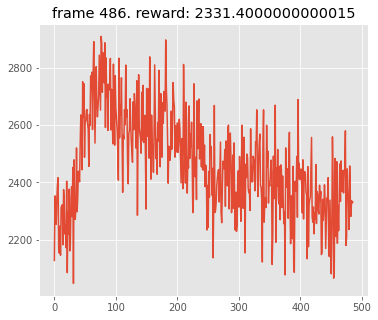

Episode 486 | Reward: 2331.40 | Revenue: 2601.00 | ServedDemand: 326.00 | Reb. Cost: 96.20 | Oper. Cost: 269.60:   1%|          | 486/50000 [4:33:07<488:14:41, 35.50s/it]

Expected q value: 435.9433898925781, torch.Size([128, 1])
torch.Size([128, 8])
Target value: 400.55780029296875, torch.Size([128, 1])
Expected new q: 435.8207702636719, torch.Size([128, 1])
Log prob: 8.513047218322754, torch.Size([128, 1])
Expected q value: 406.9189758300781, torch.Size([128, 1])
torch.Size([128, 8])
Target value: 371.19134521484375, torch.Size([128, 1])
Expected new q: 406.7706298828125, torch.Size([128, 1])
Log prob: 8.534398078918457, torch.Size([128, 1])
Expected q value: 416.0957946777344, torch.Size([128, 1])
torch.Size([128, 8])
Target value: 378.4751892089844, torch.Size([128, 1])
Expected new q: 415.9118957519531, torch.Size([128, 1])
Log prob: 8.5808687210083, torch.Size([128, 1])
Expected q value: 446.2734680175781, torch.Size([128, 1])
torch.Size([128, 8])
Target value: 408.4324035644531, torch.Size([128, 1])
Expected new q: 446.24005126953125, torch.Size([128, 1])
Log prob: 8.629446983337402, torch.Size([128, 1])
Expected q value: 393.6822509765625, torch.

Expected q value: 405.0400390625, torch.Size([128, 1])
torch.Size([128, 8])
Target value: 371.1553649902344, torch.Size([128, 1])
Expected new q: 404.9281005859375, torch.Size([128, 1])
Log prob: 8.591778755187988, torch.Size([128, 1])
Expected q value: 399.97821044921875, torch.Size([128, 1])
torch.Size([128, 8])
Target value: 362.705078125, torch.Size([128, 1])
Expected new q: 399.94189453125, torch.Size([128, 1])
Log prob: 8.549439430236816, torch.Size([128, 1])
Expected q value: 407.15704345703125, torch.Size([128, 1])
torch.Size([128, 8])
Target value: 372.37921142578125, torch.Size([128, 1])
Expected new q: 407.142578125, torch.Size([128, 1])
Log prob: 8.604055404663086, torch.Size([128, 1])
Expected q value: 430.1924133300781, torch.Size([128, 1])
torch.Size([128, 8])
Target value: 392.68206787109375, torch.Size([128, 1])
Expected new q: 430.1728210449219, torch.Size([128, 1])
Log prob: 8.60387897491455, torch.Size([128, 1])
Expected q value: 398.4041442871094, torch.Size([128, 

Episode 487 | Reward: 2185.40 | Revenue: 2448.00 | ServedDemand: 306.00 | Reb. Cost: 99.40 | Oper. Cost: 262.60:   1%|          | 487/50000 [4:33:49<513:56:57, 37.37s/it]

Expected new q: 413.9234619140625, torch.Size([128, 1])
Log prob: 8.569180488586426, torch.Size([128, 1])
Expected q value: 412.0357666015625, torch.Size([128, 1])
torch.Size([128, 8])
Target value: 376.4917297363281, torch.Size([128, 1])
Expected new q: 411.8983459472656, torch.Size([128, 1])
Log prob: 8.566625595092773, torch.Size([128, 1])
Expected q value: 397.2789611816406, torch.Size([128, 1])
torch.Size([128, 8])
Target value: 360.9072570800781, torch.Size([128, 1])
Expected new q: 397.1566467285156, torch.Size([128, 1])
Log prob: 8.586624145507812, torch.Size([128, 1])
Expected q value: 410.1837463378906, torch.Size([128, 1])
torch.Size([128, 8])
Target value: 373.28973388671875, torch.Size([128, 1])
Expected new q: 410.12646484375, torch.Size([128, 1])
Log prob: 8.567300796508789, torch.Size([128, 1])
Expected q value: 412.2564697265625, torch.Size([128, 1])
torch.Size([128, 8])
Target value: 373.4659423828125, torch.Size([128, 1])
Expected new q: 412.1117248535156, torch.Size

Expected q value: 449.5982666015625, torch.Size([128, 1])
torch.Size([128, 8])
Target value: 415.8447265625, torch.Size([128, 1])
Expected new q: 449.4998779296875, torch.Size([128, 1])
Log prob: 8.586832046508789, torch.Size([128, 1])
Expected q value: 430.80450439453125, torch.Size([128, 1])
torch.Size([128, 8])
Target value: 393.8035888671875, torch.Size([128, 1])
Expected new q: 430.5828552246094, torch.Size([128, 1])
Log prob: 8.527655601501465, torch.Size([128, 1])
Expected q value: 435.2668151855469, torch.Size([128, 1])
torch.Size([128, 8])
Target value: 396.17950439453125, torch.Size([128, 1])
Expected new q: 435.162109375, torch.Size([128, 1])
Log prob: 8.618349075317383, torch.Size([128, 1])
Expected q value: 400.0521545410156, torch.Size([128, 1])
torch.Size([128, 8])
Target value: 362.055419921875, torch.Size([128, 1])
Expected new q: 399.9894104003906, torch.Size([128, 1])
Log prob: 8.587801933288574, torch.Size([128, 1])
Expected q value: 405.7846374511719, torch.Size([1

Episode 488 | Reward: 2241.20 | Revenue: 2514.00 | ServedDemand: 308.00 | Reb. Cost: 105.20 | Oper. Cost: 272.80:   1%|          | 488/50000 [4:34:32<535:52:18, 38.96s/it]

Expected q value: 414.2943115234375, torch.Size([128, 1])
torch.Size([128, 8])
Target value: 379.0362548828125, torch.Size([128, 1])
Expected new q: 414.2209777832031, torch.Size([128, 1])
Log prob: 8.590085983276367, torch.Size([128, 1])
Expected q value: 413.0613708496094, torch.Size([128, 1])
torch.Size([128, 8])
Target value: 376.99615478515625, torch.Size([128, 1])
Expected new q: 413.0726623535156, torch.Size([128, 1])
Log prob: 8.6002197265625, torch.Size([128, 1])
Expected q value: 407.8313903808594, torch.Size([128, 1])
torch.Size([128, 8])
Target value: 368.6292419433594, torch.Size([128, 1])
Expected new q: 407.7331848144531, torch.Size([128, 1])
Log prob: 8.547101974487305, torch.Size([128, 1])


In [10]:
# book-keeping variables
training_rewards = []
training_revenue = []
training_served_demand = []
training_rebalancing_cost = []
training_operating_cost = []

# last_t_update = 0
train_episodes = 50000 # num_of_episodes_with_same_epsilon x num_of_q_tables x num_epsilons          
max_steps = 100 # maximum length of episode
epochs = trange(train_episodes) # build tqdm iterator for loop visualization

for i_episode in epochs:
    try:
        obs = env.reset()
        episode_reward = 0
        episode_revenue = 0
        episode_served_demand = 0
        episode_rebalancing_cost = 0
        episode_operating_cost = 0
        for step in range(max_steps):
            # take matching step 
            obs, paxreward, done, info = env.pax_step(CPLEXPATH=CPLEXPATH, PATH="SAC/v8/")
            episode_reward += paxreward
            # Select and perform an RL action
            x_ext = torch.tensor([obs[0][n][env.time] for n in env.region] + [env.dacc[n][env.time] for n in env.region] + \
                    [env.price[i,j][t] for t in range(env.time, env.time+1) for i,j in env.demand] + [env.time]).float()
            x_temp1 = torch.tensor([env.demand[i,j][t] for t in range(env.time, env.time+10) for i,j in env.demand]).view(1, 10, 56).float()
            x_temp2 = torch.tensor([env.dacc[n][t] for n in env.region for t in range(env.time, env.time+10)]).view(1, 10, 8).float()
            x_temp = torch.cat((x_temp1, x_temp2), dim=2)
            state = (x_ext, x_temp)
            action_rl = policy_net.get_action(state)

            # 1.2 get actual vehicle distributions vi (i.e. (x1*x2*..*xn)*num_vehicles)
            v_d = policy_net.get_desired_distribution(torch.tensor(action_rl))

            # 1.3 Solve ILP - Minimal Distance Problem 
            # 1.3.1 collect inputs and build .dat file
            t = env.time
            accTuple = [(n,int(env.acc[n][t])) for n in env.acc]
            accRLTuple = [(n, int(v_d_n)) for n, v_d_n in enumerate(v_d)]
            edgeAttr = [(i,j,env.G.edges[i,j]['time']) for i,j in env.G.edges]
            modPath = os.getcwd().replace('\\','/')+'/mod/'
            OPTPath = os.getcwd().replace('\\','/')+'/OPT/SAC/v8/'
            if not os.path.exists(OPTPath):
                os.makedirs(OPTPath)
            datafile = OPTPath + f'data_{t}.dat'
            resfile = OPTPath + f'res_{t}.dat'
            with open(datafile,'w') as file:
                file.write('path="'+resfile+'";\r\n')
                file.write('edgeAttr='+mat2str(edgeAttr)+';\r\n')
                file.write('accInitTuple='+mat2str(accTuple)+';\r\n')
                file.write('accRLTuple='+mat2str(accRLTuple)+';\r\n')

            # 2. execute .mod file and write result on file
            modfile = modPath+'minRebDistRebOnly.mod'
            if CPLEXPATH is None:
                CPLEXPATH = "/opt/ibm/ILOG/CPLEX_Studio128/opl/bin/x86-64_linux/"
            my_env = os.environ.copy()
            my_env["LD_LIBRARY_PATH"] = CPLEXPATH
            out_file =  OPTPath + f'out_{t}.dat'
            with open(out_file,'w') as output_f:
                subprocess.check_call([CPLEXPATH+"oplrun", modfile, datafile], stdout=output_f, env=my_env)
            output_f.close()

            # 3. collect results from file
            flow = defaultdict(float)
            with open(resfile,'r', encoding="utf8") as file:
                for row in file:
                    item = row.strip().strip(';').split('=')
                    if item[0] == 'flow':
                        values = item[1].strip(')]').strip('[(').split(')(')
                        for v in values:
                            if len(v) == 0:
                                continue
                            i,j,f = v.split(',')
                            flow[int(i),int(j)] = float(f)
            rebAction = [flow[i,j] for i,j in env.edges]

            # Take step
            new_obs, rebreward, done, info = env.reb_step(rebAction)
            episode_reward += rebreward
            x_ext = torch.tensor([new_obs[0][n][env.time] for n in env.region] + [env.dacc[n][env.time] for n in env.region] + \
                    [env.price[i,j][t] for t in range(env.time, env.time+1) for i,j in env.demand] + [env.time]).float()
            x_temp1 = torch.tensor([env.demand[i,j][t] for t in range(env.time, env.time+10) for i,j in env.demand]).view(1, 10, 56).float()
            x_temp2 = torch.tensor([env.dacc[n][t] for n in env.region for t in range(env.time, env.time+10)]).view(1, 10, 8).float()
            x_temp = torch.cat((x_temp1, x_temp2), dim=2)
            new_state = (x_ext, x_temp)

            # Store the transition in memory
            replay_buffer.push(state[0].numpy(), state[1].numpy(), np.array(action_rl), paxreward + rebreward, new_state[0].numpy(), new_state[1].numpy(), done)
            
            if len(replay_buffer) > batch_size:
                soft_q_update(batch_size)
                
            # Move to the next state
            # track performance over episode
            episode_revenue += info['revenue']
            episode_served_demand += info['served_demand']
            episode_rebalancing_cost += info['rebalancing_cost']
            episode_operating_cost += info['operating_cost']
            obs, state = deepcopy(new_obs), deepcopy(new_state)
            
            
            if done:
                break
        
        epochs.set_description(f"Episode {i_episode+1} | Reward: {episode_reward:.2f} | Revenue: {episode_revenue:.2f} | ServedDemand: {episode_served_demand:.2f} \
| Reb. Cost: {episode_rebalancing_cost:.2f} | Oper. Cost: {episode_operating_cost:.2f}")
        #Adding the total reward and reduced epsilon values
        training_rewards.append(episode_reward)
        training_revenue.append(episode_revenue)
        training_served_demand.append(episode_served_demand)
        training_rebalancing_cost.append(episode_rebalancing_cost)
        training_operating_cost.append(episode_operating_cost)
        
        if i_episode % 5 == 0:
            plot(i_episode+1, training_rewards)
            
    except KeyboardInterrupt:
        break

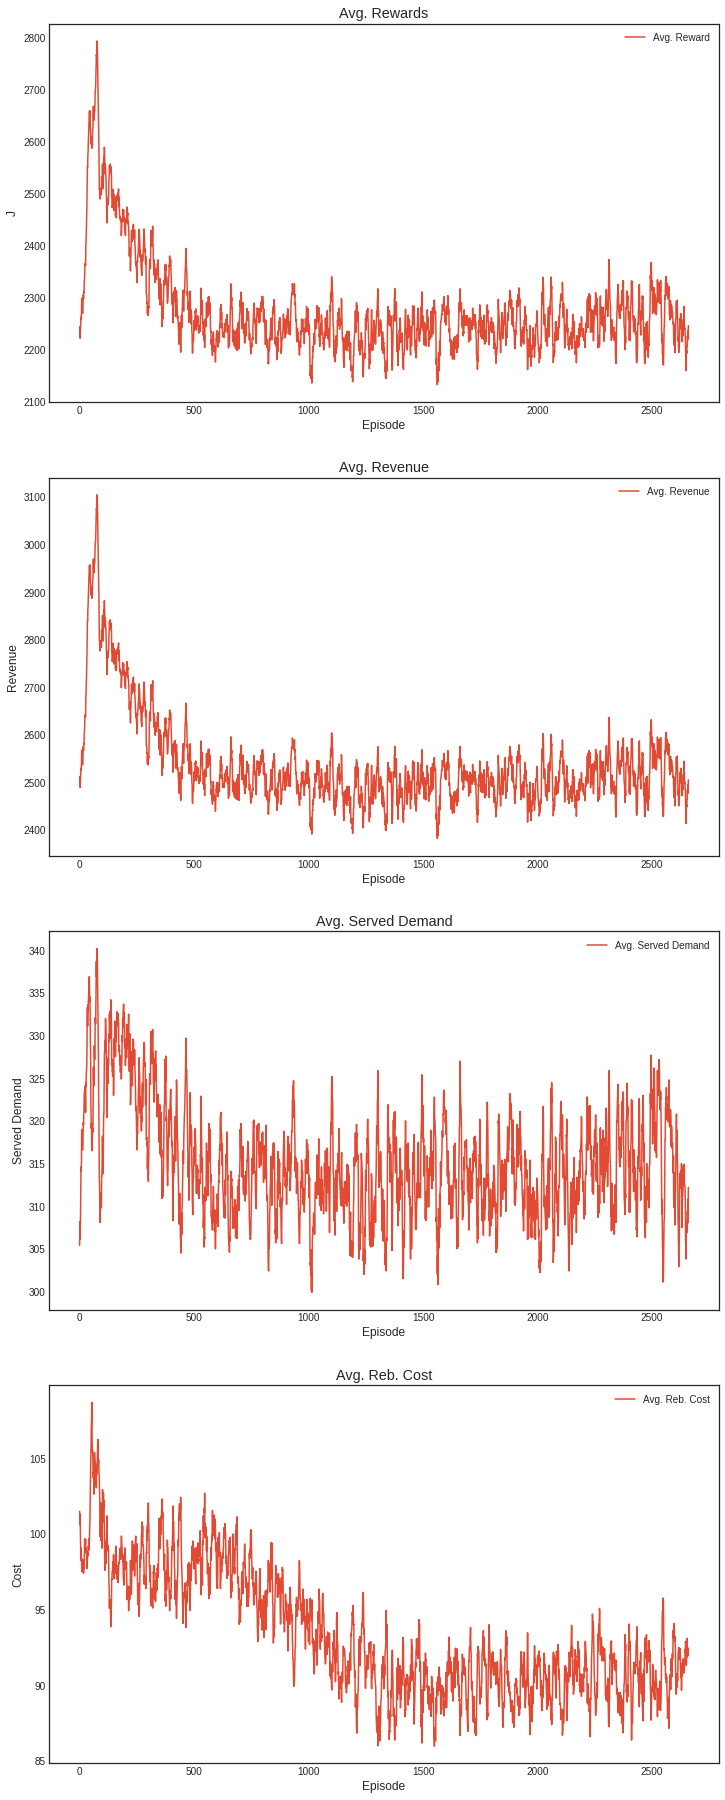

In [11]:
# Plot results with moving average smoothing 
plt.style.use("seaborn-white")
fig = plt.figure(figsize=(12,32))
fig.add_subplot(411)
plt.plot(moving_average(training_rewards, n=10), label="Avg. Reward")
plt.title("Avg. Rewards")
plt.xlabel("Episode")
plt.ylabel("J")
plt.legend()

fig.add_subplot(412)
plt.plot(moving_average(training_revenue, n=10), label="Avg. Revenue")
plt.title("Avg. Revenue")
plt.xlabel("Episode")
plt.ylabel("Revenue")
plt.legend()

fig.add_subplot(413)
plt.plot(moving_average(training_served_demand, n=10), label="Avg. Served Demand")
plt.title("Avg. Served Demand")
plt.xlabel("Episode")
plt.ylabel("Served Demand")
plt.legend()

fig.add_subplot(414)
plt.plot(moving_average(training_rebalancing_cost, n=10), label="Avg. Reb. Cost")
plt.title("Avg. Reb. Cost")
plt.xlabel("Episode")
plt.ylabel("Cost")
plt.legend()
plt.show()

### Test

In [27]:
# three levels
scenario = Scenario(sd=10,demand_input = {(1,6):2, (0,7):2, 'default':0.1}, fix_price=True) # uni-directional
env = AMoD(scenario)
model.env = env

In [28]:
from tqdm import trange

test_episodes = 100
max_steps = 100
epochs = trange(test_episodes) # build tqdm iterator for loop visualization
np.random.seed(10)

test_rewards = []
test_revenue = []
test_served_demand = []
test_rebalancing_cost = []
test_operating_cost = []
action_list = []

for episode in epochs:
    try:
        episode_reward = 0
        episode_revenue = 0
        episode_served_demand = 0
        episode_rebalancing_cost = 0
        episode_operating_cost = 0
        episode_action_list = []
        obs = env.reset()
        done = False
        while(not done):
            # take matching step 
            obs, paxreward, done, info = env.pax_step(CPLEXPATH=CPLEXPATH, PATH="AC/v9/")
            episode_reward += paxreward
            # Select and perform an RL action
            x_ext = torch.tensor([obs[0][n][env.time] for n in env.region] + [env.dacc[n][env.time] for n in env.region] + \
                    [env.price[i,j][t] for t in range(env.time, env.time+1) for i,j in env.demand] + [env.time]).float()
            x_temp = torch.tensor([env.demand[i,j][t] for t in range(env.time, env.time+10) for i,j in env.demand]).view(1, 10, 56).float()
            state = (x_ext, x_temp)
            with torch.no_grad():
                c, _ = model(state[0], state[1])
                action_rl = list(c.numpy()/c.numpy().sum())
            episode_action_list.append(action_rl)

            # 1.2 get actual vehicle distributions vi (i.e. (x1*x2*..*xn)*num_vehicles)
            v_d = model.get_desired_distribution(torch.tensor(action_rl))

            # 1.3 Solve ILP - Minimal Distance Problem 
            # 1.3.1 collect inputs and build .dat file
            t = env.time
            accTuple = [(n,int(env.acc[n][t])) for n in env.acc]
            accRLTuple = [(n, int(v_d_n)) for n, v_d_n in enumerate(v_d)]
            edgeAttr = [(i,j,env.G.edges[i,j]['time']) for i,j in env.G.edges]
            modPath = os.getcwd().replace('\\','/')+'/mod/'
            OPTPath = os.getcwd().replace('\\','/')+'/OPT/AC/v9/'
            if not os.path.exists(OPTPath):
                os.makedirs(OPTPath)
            datafile = OPTPath + f'data_{t}.dat'
            resfile = OPTPath + f'res_{t}.dat'
            with open(datafile,'w') as file:
                file.write('path="'+resfile+'";\r\n')
                file.write('edgeAttr='+mat2str(edgeAttr)+';\r\n')
                file.write('accInitTuple='+mat2str(accTuple)+';\r\n')
                file.write('accRLTuple='+mat2str(accRLTuple)+';\r\n')

            # 2. execute .mod file and write result on file
            modfile = modPath+'minRebDistRebOnly.mod'
            if CPLEXPATH is None:
                CPLEXPATH = "/opt/ibm/ILOG/CPLEX_Studio128/opl/bin/x86-64_linux/"
            my_env = os.environ.copy()
            my_env["LD_LIBRARY_PATH"] = CPLEXPATH
            out_file =  OPTPath + f'out_{t}.dat'
            with open(out_file,'w') as output_f:
                subprocess.check_call([CPLEXPATH+"oplrun", modfile, datafile], stdout=output_f, env=my_env)
            output_f.close()

            # 3. collect results from file
            flow = defaultdict(float)
            with open(resfile,'r', encoding="utf8") as file:
                for row in file:
                    item = row.strip().strip(';').split('=')
                    if item[0] == 'flow':
                        values = item[1].strip(')]').strip('[(').split(')(')
                        for v in values:
                            if len(v) == 0:
                                continue
                            i,j,f = v.split(',')
                            flow[int(i),int(j)] = float(f)
            rebAction = [flow[i,j] for i,j in env.edges]

            new_obs, rebreward, done, info = env.reb_step(rebAction)
            episode_reward += rebreward
            x_ext = torch.tensor([new_obs[0][n][env.time] for n in env.region] + [env.dacc[n][env.time] for n in env.region] + \
                    [env.price[i,j][t] for t in range(env.time, env.time+1) for i,j in env.demand] + [env.time]).float()
            x_temp = torch.tensor([env.demand[i,j][t] for t in range(env.time, env.time+10) for i,j in env.demand]).view(1, 10, 56).float()
            new_state = (x_ext, x_temp)
            
            episode_served_demand += info['served_demand']
            episode_rebalancing_cost += info['rebalancing_cost']
            episode_operating_cost += info['operating_cost']
            episode_revenue += info['revenue']
        epochs.set_description(f"Episode {episode+1} | Reward: {episode_reward:.2f} | Revenue: {episode_revenue:.2f} | ServedDemand: {episode_served_demand:.2f} \
| Reb. Cost: {episode_rebalancing_cost} | Oper. Cost: {episode_operating_cost:.2f}")
        #Adding the total reward and reduced epsilon values
        test_rewards.append(episode_reward)
        test_revenue.append(episode_revenue)
        test_served_demand.append(episode_served_demand)
        test_rebalancing_cost.append(episode_rebalancing_cost)
        test_operating_cost.append(episode_operating_cost)
        action_list.append(episode_action_list)
        break
    except KeyboardInterrupt:
        break





  0%|          | 0/100 [00:00<?, ?it/s]



Episode 1 | Reward: 2728.60 | Revenue: 3039.00 | ServedDemand: 318.00 | Reb. Cost: 107.8 | Oper. Cost: 310.40:   0%|          | 0/100 [00:05<?, ?it/s]